# Tax Calculation for Zürich

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

## Type of Taxes

### Einkommensteuer
Individual's income, which includes earnings from employment, self-employment, pensions, and investments.

### Vermögensteuer
Wealth of a person, which includes the total value of their assets such as real estate, bank accounts, securities. The rates are generally low, often ranging from a fraction of a percent to a few percent.

## Tax rates (Tarif)

### Grundtarif (Basic Rate)
This is the tax rate applied to single individuals. It is typically higher per unit of income compared to the married rate.

### Verheiratetentarif (Married Rate)
This rate applies to married couples and registered partners. These rates are generally more favorable than the basic rate.

In [2]:
class TaxType(Enum):
    EINKOMMEN = 1
    VERMOEGEN = 2

class Tarif(Enum):
    GRUNDTARIF = 1
    VERHEIRATETENTARIF = 2

Each of Switzerland's 26 cantons has its own tax system, meaning that both rates and calculations can vary from one canton to another. The Canton of Zurich has a progressive tax rate system for income and wealth taxes. This means that as an individual's income increases, the tax rate applied to that income also increases.
Tax rates in Zurich are detailed in "Tarif Tabellen" (tax rate tables), which provide the specific tax amounts on various levels of income and wealth as well as the Tarif (Single or Married). 

The tax rate tables for Zurich can be found on the Cantons website: [Steuertarife 2018 PDF](https://www.zh.ch/content/dam/zhweb/bilder-dokumente/themen/steuern-finanzen/steuern/natuerlichepersonen/steuertarife/steuertarif_2018_staatssteuer_bundessteuer.pdf)

To load the tariftablle execute the following code, change TaxType and Tarif to the desired values:

In [3]:

def select_tariftabelle(year, tax_type: TaxType, tarif: Tarif):
    filename = f"./tariftabellen/{year}-{tax_type.name.lower()}-{tarif.name.lower()}.csv"
    if tax_type == TaxType.EINKOMMEN:
        names = ['Einkommensbereich (CHF)', 'Steuer Grundtarif (CHF)', 'Zusätzlicher Steuerbetrag pro 100 CHF']
    else:
        names = ['steuerbares Vermögen (CHF)', 'Steuer (CHF)', 'für je weitere 1000. Vemögen']
    return pd.read_csv(filename, names=names, skiprows=1, header=None)

select_tariftabelle(2018, TaxType.EINKOMMEN, Tarif.VERHEIRATETENTARIF)

,Einkommensbereich (CHF),Steuer Grundtarif (CHF),Zusätzlicher Steuerbetrag pro 100 CHF
0,13500,0,2
1,19600,122,3
2,27300,353,4
3,36700,729,5
4,47400,1264,6
5,61300,2098,7
6,92100,4254,8
7,122900,6718,9
8,169300,10894,10
9,224700,16434,11


Visualize the progression of the tax rate for the Canton of Zurich:

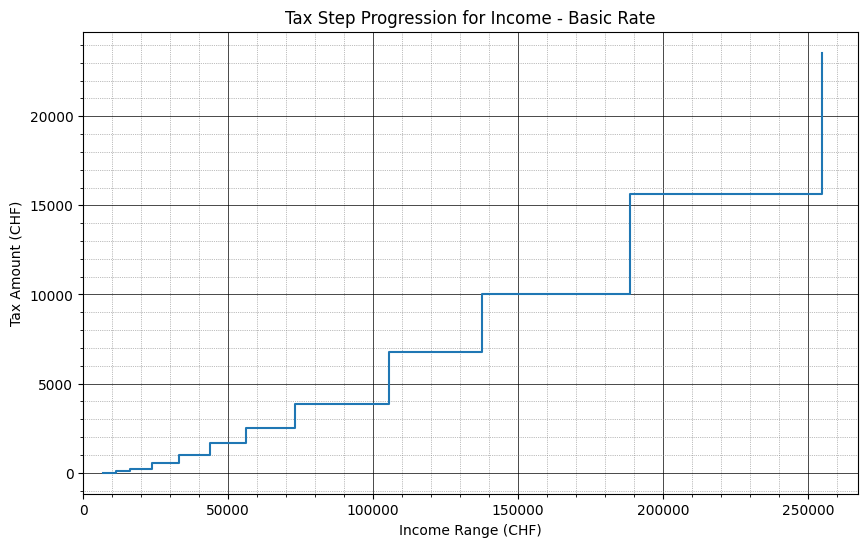

In [4]:
tarif_tabelle_einkommen = select_tariftabelle(2018, TaxType.EINKOMMEN, Tarif.GRUNDTARIF)

plt.figure(figsize=(10, 6))
plt.step(tarif_tabelle_einkommen['Einkommensbereich (CHF)'], tarif_tabelle_einkommen['Steuer Grundtarif (CHF)'], where='post')
plt.xlabel('Income Range (CHF)')
plt.ylabel('Tax Amount (CHF)')
plt.title('Tax Step Progression for Income - Basic Rate')
plt.xlim(left=0)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

## Einfache Steuer (Simple Tax)

- **Einfache Steuer**: Calculated as a percentage of the income.
- **Steuer Grundtarif**: Selected from the tariff table based on the range of the `satzbestimmendes Einkommen`.
- **Satzbestimmendes Einkommen**: The income that determines the tax rate. This differs from the total income, as certain deductions are made before the tax rate is applied.
- **Einkommensbereich**: The actual taxable income of the taxpayer.
- **Zusätzlicher Steuerbetrag pro 100 CHF**: The additional tax amount per 100 CHF of income above the `Einkommensbereich`.
- **Satz**: The tax rate is calculated as a percentage of the `satzbestimmendes Einkommen`. This is the rate at which the tax is applied to the income.

Formula for the Berechnete Steuer:

$$
\text{Berechnete Steuer (CHF)} = \text{Steuer Grundtarif (CHF)} + \left(\frac{\text{Satzbestimmendes Einkommen (CHF)} - \text{Einkommensbereich (CHF)}}{100}\right) \times \text{Zusätzlicher Steuerbetrag pro 100 CHF}
$$

Formula for the Satz:

$$
\text{Satz} = \frac{\text{Berechnete Steuer (CHF)} \times 100}{\text{Satzbestimmendes Einkommen (CHF)}}
$$

Formula for the Einfache Steuer:
$$
\text{Einfache Steuer (CHF)} = \frac{\text{Einkommen (CHF)}}{100} \times \text{Satz}
$$

In [17]:

def calculate_einfache_steuer_einkommen(year, tarif: Tarif, einkommen, satzbestimmend):
    data = select_tariftabelle(year, TaxType.EINKOMMEN, tarif)
    first_bracket = data.iloc[0]
    if satzbestimmend <= first_bracket.iloc[0]:
        return 0
    
    current_bracket = first_bracket
    for bracket in data.itertuples():
        if satzbestimmend < bracket[1]:
            break
        else:
            current_bracket = bracket
    berechnete_steuer = current_bracket[2] + (satzbestimmend - current_bracket[1]) / 100 * current_bracket[3]
    satz = berechnete_steuer / (satzbestimmend / 100) # pro 100 CHF
    betrag = einkommen / 100 * satz
    return {
        'satz': satz,
        'betrag': betrag
    }

einfche_steuer = calculate_einfache_steuer_einkommen(2018, Tarif.GRUNDTARIF, 80000, 100000)
print("Einfache Steuer Einkommen: ", "{:.2f}".format(einfche_steuer['betrag']), "CHF")
print("Satz: ", "{:.2f}".format(einfche_steuer['satz']), "%")

Einfache Steuer:  5036.80 CHF
Satz:  6.30 %


The same formulas are used for the Vermögensteuer. Since there is no satzbestimmendes Vermögen, the tax rate is applied to the total wealth of the individual.

In [18]:

def calculate_einfache_steuer_vermoegen(year, tarif: Tarif, vermoegen):
    data = select_tariftabelle(year, TaxType.VERMOEGEN, tarif)
    first_bracket = data.iloc[0]
    if vermoegen <= first_bracket.iloc[0]:
        return 0
    current_bracket = first_bracket
    for bracket in data.itertuples():
        if vermoegen < bracket[1]:
            break
        else:
            current_bracket = bracket
    betrag = current_bracket[2] + (vermoegen - current_bracket[1]) / 1000 * current_bracket[3]
    satz = betrag / (vermoegen / 100)
    return {
        'satz': satz,
        'betrag': betrag
    }
    
einfche_steuer = calculate_einfache_steuer_vermoegen(2018, Tarif.VERHEIRATETENTARIF, 250000)
print("Einfache Steuer Vermögen: ", "{:.2f}".format(einfche_steuer['betrag']), "CHF")
print("Satz: ", "{:.2f}".format(einfche_steuer['satz']), "%")

Einfache Steuer Vermögen:  48.00 CHF
Satz:  0.02 %


The total Staats- und Gemeindesteuer combines both income and wealth in Switzerland. The total tax is the sum of two components:
    * Einfache Steuer Einkommen
    * Einfache Steuer Vermögen

Each component is calculated by applying respective tax rates from the cantonal (Kantonssteuerfuss) and municipal (Gemeindesteuerfuss):

$$
\text{{Staats- u. Gemeindesteuer}} = (\text{{Einfache Steuer Einkommen}} \cdot (\text{{Kantonssteuerfuss}} + \text{{Gemeindesteuerfuss}})) + (\text{{Einfache Steuer Vermögen}} \cdot (\text{{Kantonssteuerfuss}} + \text{{Gemeindesteuerfuss}}))
$$

In [7]:
def calculate_staats_gemeinde_steuern(year, tarif: Tarif, einkommen, satzbestimmend, vermoegen):
    einfache_steuer_einkommen = calculate_einfache_steuer_einkommen(year, tarif, einkommen, satzbestimmend)['betrag']
    einfache_steuer_vermoegen = calculate_einfache_steuer_vermoegen(year, tarif, vermoegen)['betrag']
    staatssteuerfuss = 0.99  # Example value, replace with actual method to fetch the tax rate
    gemeindesteuerfuss = 1.19

    total_steuer_einkommen = einfache_steuer_einkommen * (staatssteuerfuss + gemeindesteuerfuss)
    total_steuer_vermoegen = einfache_steuer_vermoegen * (staatssteuerfuss + gemeindesteuerfuss)

    return total_steuer_einkommen + total_steuer_vermoegen

staats_gemeinde_steuer = calculate_staats_gemeinde_steuern(
    year = 2018, 
    tarif = Tarif.VERHEIRATETENTARIF, 
    einkommen = 80000, 
    satzbestimmend = 100000, 
    vermoegen = 250000
)
print(f"Staats- u. Gemeindesteuer: {staats_gemeinde_steuer:.2f} CHF")

Staats- u. Gemeindesteuer: 8625.82 CHF
